In [22]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, UpSampling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt

# Step 1 - Preparing dataset

In [ ]:
import random

def get_input_output_paths(root_dir, sub_dirs, max_samples=None):
    input_paths = []
    target_paths = []
    samples_per_dir = max_samples // len(sub_dirs) if max_samples else None
    for sub_dir in sub_dirs:
        input_dir = os.path.join(root_dir, sub_dir, 'image')
        sub_input_paths = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
        random.shuffle(sub_input_paths)
        sub_target_paths = list(map(lambda x: x.replace("image", "indexLabel"), sub_input_paths))
        
        if samples_per_dir:
            sub_input_paths = sub_input_paths[:samples_per_dir]
            sub_target_paths = sub_target_paths[:samples_per_dir]
        
        input_paths.extend(sub_input_paths)
        target_paths.extend(sub_target_paths)
    return input_paths, target_paths

# get_input_output_paths('WildScenes2d', ['K-01', 'K-02', 'K-03', 'V-01', 'V-02'], 100)

In [23]:
import random

input_dir = "V-01/image/"
target_dir = "V-01/indexLabel"
img_size = (512, 512)
num_classes = 19
batch_size = 4
input_size = 100

input_img_paths = [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]

random.shuffle(input_img_paths)

target_img_paths = list(map(lambda x: x.replace("image", "indexLabel"), input_img_paths))

input_img_paths = input_img_paths[:input_size]
target_img_paths = target_img_paths[:input_size]


print("Number of samples:", len(input_img_paths))


Number of samples: 100


In [24]:
def load_mask(img_path):
    target_img = tf_io.read_file(img_path)
    target_img = tf_io.decode_png(target_img, channels=1)
    target_img = tf_image.convert_image_dtype(target_img, "uint8")
    
    return target_img

def load_image(img_path):
    input_img = tf_io.read_file(img_path)
    input_img = tf_io.decode_png(input_img, channels=3)
    input_img = tf_image.resize(input_img, img_size)
    input_img = tf_image.convert_image_dtype(input_img, "float32") / 255.0
    
    return input_img

def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""
    
    def one_hot_encode(masks, num_classes):
        masks_encoded = np.zeros((*masks.shape, num_classes), dtype=np.float32)
        for i in range(num_classes):
            masks_encoded[..., i] = (masks == i).astype(np.float32)
        return masks_encoded

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32") / 255.0

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=1)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")
        
    
        return input_img, target_img

    # limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
        
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [25]:
from sklearn.model_selection import train_test_split

# TODO: implement stratified sampling later on full data set

def train_val_test_split(input_img_paths, target_img_paths, test_size=0.2, validation_size=0.2):
    X_train, X_test, y_train, y_test = train_test_split(input_img_paths, target_img_paths, test_size=test_size, random_state=42)
    X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=validation_size/(1-test_size), random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(input_img_paths, target_img_paths)

print("Number of train samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test))

train_dataset = get_dataset(
    batch_size,
    img_size,
    X_train,
    y_train,
)

valid_dataset = get_dataset(
    batch_size,
    img_size,
    X_val,
    y_val,
)

Number of train samples: 60
Number of validation samples: 20
Number of test samples: 20


In [26]:
def unet_model(shape, num_classes):
    def conv_block(inputs, filters, pool=True):
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        x = Conv2D(filters, 3, padding="same")(inputs)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
    
        if pool == True:
            p = MaxPooling2D((2, 2))(x)
            return x, p
        else:
            return x
        
    inputs = Input(shape)

    # Encoder Layer
    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    # Bridge Layer
    b1 = conv_block(p4, 128, pool=False)

    # Decoder Layer
    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)
    
    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)
    
    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    # Output layer
    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)
    return Model(inputs, output)

model = unet_model((512, 512, 3), num_classes)
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 512, 512,  │        448 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512, 512,  │         64 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 512, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 256, 256,  │          0 │ activation_37[0]… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 256, 256,  │      4,640 │ max_pooling2d_8[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 128, 128,  │          0 │ activation_39[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 128, 128,  │     13,872 │ max_pooling2d_9[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        192 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_41       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ activation_41[0]… │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 64, 64,    │     27,712 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ activation_43[0]

 Total params: 311,731 (1.19 MB)

 Trainable params: 310,835 (1.19 MB)

 Non-trainable params: 896 (3.50 KB)

None


In [27]:
class CustomMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes=None, name=None, dtype=None):
        super(CustomMeanIoU, self).__init__(
            num_classes=num_classes, name=name, dtype=dtype
        )

    @tf.function(reduce_retracing=True)
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.squeeze(y_true, axis=-1)
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

model.compile(optimizer=Adam(1e-4), loss="sparse_categorical_crossentropy", metrics=[CustomMeanIoU(num_classes=num_classes, name="mIoU")])

model_file="models/unet_model_312.keras"

callbacks = [
    ModelCheckpoint("models/unet_model_312.keras", save_best_only=True)
]

epochs = 3

model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    shuffle=True,
    verbose=1,
)

Epoch 1/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 3.0488 - mIoU: 0.0170 - val_loss: 2.9280 - val_mIoU: 0.0047
Epoch 2/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 2.7344 - mIoU: 0.0436 - val_loss: 2.9792 - val_mIoU: 0.0101
Epoch 3/3
15/15 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - loss: 2.5792 - mIoU: 0.0614 - val_loss: 3.0451 - val_mIoU: 0.0231


In [28]:
valid_dataset = get_dataset(
    batch_size,
    img_size,
    X_val,
    y_val,
)

val_preds = model.predict(valid_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 332ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
[[14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 ...
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]
 [14 14 14 ... 14 14 14]]


(-0.5, 2015.5, 1511.5, -0.5)

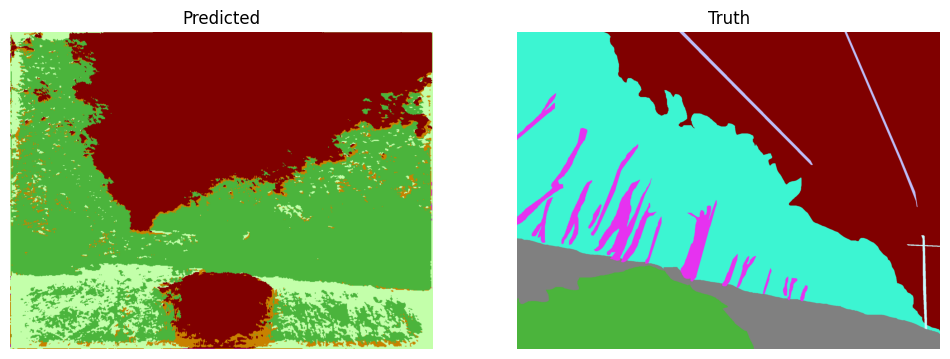

In [30]:
colours = [[0, 0, 0], 
           [75, 25, 230], 
           [75, 180, 60], 
           [25, 225, 255], 
           [200, 130, 0], 
           [180, 30, 145], 
           [240, 240, 70], 
           [230, 50, 240], 
           [60, 245, 210], 
           [75, 25, 230], 
           [128, 128, 0], 
           [40, 110, 170], 
           [200, 250, 255], 
           [0, 0, 128], 
           [195, 255, 170], 
           [0, 128, 128], 
           [190, 190, 250], 
           [128, 0, 0], 
           [128, 128, 128]]

# test_sample = "1623379829-508641462.png"
test_sample = "1623378124-681919295.png"
original_size = (1512, 2016)

truth_labels = load_mask("V-01/indexLabel/" + test_sample)
truth_img = np.array([[colours[num] for num in row] for row in np.array(truth_labels).reshape(1512, 2016)])

test_img = load_image("V-01/image/" + test_sample)
prediction = model.predict(np.expand_dims(test_img, axis=0))
# prediction = val_preds[]
resized = input_img = tf_image.resize(val_preds[1], original_size, method="nearest")
predicted_labels = np.argmax(resized, axis=-1)
print(predicted_labels)
predicted_img = np.array([[colours[num] for num in row] for row in predicted_labels])


import matplotlib.pyplot as plt

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first image on the first subplot
axes[0].imshow(predicted_img)
axes[0].set_title('Predicted')
axes[0].axis('off')  # Hide axes

# Plot the second image on the second subplot
axes[1].imshow(truth_img)
axes[1].set_title('Truth')
axes[1].axis('off')  # Hide axes